# Comparing Document Embeddings

The goal of this notebook is to make use of some of the tools in our ``vectorizers`` library to construct document embeddings, and to compare those document embeddings with results one might see from currently popular techniques such as Universal Sentence Encoder or BERT sentence embeddings. At this point ``vectorizers`` is still a research project, so this is not meant to be a fully rigorous comparison so much as a demonstration of general relative performance.

In [ ]:
from src import paths
from src.data import Dataset

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.datasets
import sklearn.feature_extraction.text
import sklearn.preprocessing
import scipy.sparse
import vectorizers
import vectorizers.transformers
import umap
import umap.plot
import pynndescent
import seaborn as sns
import matplotlib.colors
import warnings
      
warnings.simplefilter("ignore")
sns.set()

We will, of course, need some data to work with. For the purposes of this simple test we will make use of the 20 newsgroups dataset. In practice this is really a toy dataset, but it offers enough complications to see how well we can piece together document embeddings using ``vectorizers``.

We will, however, so a little pruning: the 20 newsgroups dataset contains some very short posts (once the headers, footers and quotes are removed) that will definitely muddy up the results. We will therefore prune out any post less than (a somewhat arbitrary) 200 characters.

In [ ]:
ds = Dataset.load('20_newsgroups')

In [ ]:
long_enough = [len(t) > 200 for t in ds.data]
targets = np.array(ds.target)[long_enough]
news_data = [t for t in ds.data if len(t) > 200]

The target data for 20 newsgroups is the particular newsgroup the post was sent to. In practice there are broad groups that the specific newsgroups can be classified into, such as religion, politics, computing, sport and science. While some of this can be gleaned programmatically from the newsgroup name (with its dotted hierarchy), some things (like alt.atheism being in the religion topic) require more care. We will hand curate the newsgroups into 6 major broad categories.

In [ ]:
religion = ("alt.atheism", "talk.religion.misc", "soc.religion.christian")
politics = ("talk.politics.misc", "talk.politics.mideast", "talk.politics.guns")
sport = ("rec.sport.baseball", "rec.sport.hockey")
comp = (
    "comp.graphics",
    "comp.os.ms-windows.misc",
    "comp.sys.ibm.pc.hardware",
    "comp.sys.mac.hardware",
    "comp.windows.x",
)
sci = (
    "sci.crypt",
    "sci.electronics",
    "sci.med",
    "sci.space",
)
misc = (
    "misc.forsale",
    "rec.autos",
    "rec.motorcycles",
)

The goal of this is that we can now create a custom color palette for the data when visualizing results such that different newsgroups in the same category can have similar colours.

In [ ]:
color_key = {}
for l, c in zip(religion, sns.color_palette("Blues", 4)[1:]):
    color_key[l] = matplotlib.colors.rgb2hex(c)
for l, c in zip(politics, sns.color_palette("Purples", 4)[1:]):
    color_key[l] = matplotlib.colors.rgb2hex(c)
for l, c in zip(comp, sns.color_palette("YlOrRd", 5)):
    color_key[l] = matplotlib.colors.rgb2hex(c)
for l, c in zip(sci, sns.color_palette("light:teal", 5)[1:]):
    color_key[l] = matplotlib.colors.rgb2hex(c)
for l, c in zip(sport, sns.color_palette("light:#660033", 4)[1:3]):
    color_key[l] = matplotlib.colors.rgb2hex(c)
for l, c in zip(misc, sns.color_palette("YlGn", 4)[1:]):
    color_key[l] = matplotlib.colors.rgb2hex(c)

With a dataset and a carefully designed color palette we are now in good shape to do some qualitative analysis, using UMAP, of different document embedding methods.

# Universal Sentence Encoder

First up is the Universal Sentence Encoder (USE) from Google. USE makes use of a Deep Averaging Network and supervised training to learn a document embedding. It is simultaneously very powerful and very opaque. While papers describe USE's overall architecture and broad design choices, the exact details, pre-training corpus, etc. are not so clear. On the other hand it does a remarkably good job and embedding sentences and short documents in a useful and coherent way. We will use the standard "out of the box" approach and just load the model directly from tensorflow_hub.

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub

In [ ]:
use_embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

USE is extremely simple to use -- we can pass it the raw text and not worry about fiddly details such as tokenization or other preprocessing. What we get back is a set of vectors, one for each document, that hopefully captures useful information.

In [ ]:
%%time
#use_vectors = use_embed(news_data).eval(session=tf.compat.v1.Session())
use_vectors = use_embed(news_data).numpy() # requires Tensorflow 2.0+

We can pass the results of USE into UMAP and plot the results, making use of our custom color palette, so see how well USE has managed to represent 20 newsgroups. Ideally we would like to see different newsgroups reasonably well separated, although the data is very noisy and several newsgroups have closely overlapping content, so perfect results are far too much to hope for.

We can pass the results of USE into UMAP and plot the results, making use of our custom color palette, so see how well USE has managed to represent 20 newsgroups. Ideally we would like to see different newsgroups reasonably well separated, although the data is very noisy and several newsgroups have closely overlapping content, so perfect results are far too much to hope for.

In [ ]:
use_mapper = umap.UMAP(metric="cosine", random_state=42).fit(use_vectors)

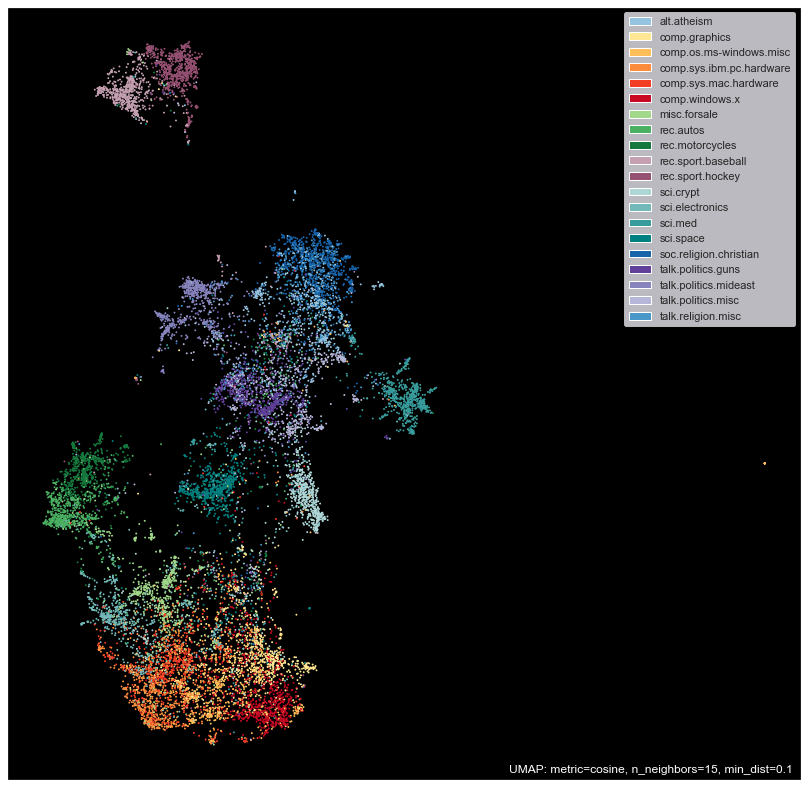

In [10]:
umap.plot.points(
    use_mapper,
    labels=np.array([news.target_names[x] for x in targets]),
    color_key=color_key,
    background="black",
    width=1024,
    height=1024,
)
plt.savefig(paths['figures_path'] / "universal_sentence_encoder.png", facecolor="none")

The results are fairly impressive -- several of the newsgroups are well separated, and the remainder are, at least, largely grouped with newsgroups of a similar colour, showing that USE is grouping posts on similar topics. There is still a fair amount of noise floating around, but that is only to be expected: as already noted the newgroups data is very messy.

# BERT Sentence Transformer

Next up is BERT, again from Google. BERT uses a pretrained transformer architecture. BERT has been primarily designed for use in downstream task applications with the expectation that users will do fine-tuning training specific to the task. For general use in sentence embedding we turn to the ``sentence_transformers`` library which has used a siamese achitecture to do fine tuning training on the task of sentence similarity. This is not necessarily the best way to use BERT for the various tasks we are applying it to here, but it is simple to get up an running and is the most commonly used approach among practitioners for the problem of sentence embedding with BERT.

In [11]:
from sentence_transformers import SentenceTransformer

2021-05-15 14:53:25,722 - file_utils - INFO - TensorFlow version 2.0.0 available.
2021-05-15 14:53:25,723 - file_utils - INFO - PyTorch version 1.8.1 available.
2021-05-15 14:53:25,759 - modeling_xlnet - INFO - Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex .


The ``sentence_transformers`` library requires is to load a specific BERT model. In this case for the sake of simplicity we'll choose a small basic BERT model, frequenctly used as a baseline BERT model for sentence embedding tasks.

In [12]:
sent_trans_model = SentenceTransformer("stsb-distilbert-base")

2021-05-15 14:53:25,795 - SentenceTransformer - INFO - Load pretrained SentenceTransformer: stsb-distilbert-base
2021-05-15 14:53:25,795 - SentenceTransformer - INFO - Did not find folder stsb-distilbert-base
2021-05-15 14:53:25,796 - SentenceTransformer - INFO - Search model on server: http://sbert.net/models/stsb-distilbert-base.zip
2021-05-15 14:53:25,799 - SentenceTransformer - INFO - Load SentenceTransformer from folder: /Users/kjell/.cache/torch/sentence_transformers/sbert.net_models_stsb-distilbert-base
2021-05-15 14:53:25,802 - configuration_utils - INFO - loading configuration file /Users/kjell/.cache/torch/sentence_transformers/sbert.net_models_stsb-distilbert-base/0_Transformer/config.json
2021-05-15 14:53:25,803 - configuration_utils - INFO - Model config {
  "activation": "gelu",
  "architectures": [
    "DistilBertModel"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "finetuning_task": null,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_pos

Once we have the model loaded (it may take a while to download -- it is a very large model) actually encoding the newsgroup posts is, as with USE, very straightforward, in this case just requiring us to use the ``encode`` method. Note that since we are running without a GPU this will take quite a bit longer than it might with better hardware.

In [13]:
%%time
bert_vectors = sent_trans_model.encode(news_data, show_progress_bar=False)

TypeError: 'DistilBertTokenizer' object is not callable

As with USE we can pass the results into UMAP to get an overall qualitative look at how well we are doing at sentence embedding. As before our hope is to see some level of separation of the different newsgroups, and at the very least managing to group the broad categories of newsgroup together (hopefully easier to see with the custom colour palette).

In [14]:
%%time
bert_mapper = umap.UMAP(metric="cosine", random_state=42).fit(bert_vectors)

NameError: name 'bert_vectors' is not defined

In [ ]:
umap.plot.points(
    bert_mapper,
    labels=np.array([ds.metadata['target_names'][x] for x in targets]),
    color_key=color_key,
    background="black",
    width=1024,
    height=1024,
)
plt.savefig(paths['figures_path'] / "bert.png", facecolor="none")

This is, perhaps, a little underwhelming given the general view that BERT is the state-of-the-art for pretty much any NLP task. To be fair to BERT, this is not how it is expected to be used by the original developers -- we haven't done custom fine-tuning. On the other had, as noted above, this *is* how BERT commonly gets used for sentence embedding in practice (in large part, I suspect, because this approach is very easy to use). It will suffice as a representative example of basic BERT embeddings as often used by practitioners.

# Vectorizers library

Having looked at USE and BERT let's turn our attention to what we can get done with fairly simple transformations, and without having to resort to pre-trained neural networks. For this I'll be using the [``vectorizers`` library from the Tutte Institute](https://github.com/TutteInstitute/vectorizers). This library will provide most of the building blocks we need to build a variety of different document embeddings. To help clarify what is going on we'll step through the process slowly, showing the different branching off points. This means that the process of building the document embeddings will involve more steps than was required with the easy to use APIs provided by BERT and USE, but hopefully it will be clear that it is not that hard to glue much of the pieces here together into simple sklearn pipelines or similar.

The first thing to note, however, is that the ``vectorizers`` library is not really built for text -- instead the library is designed to cope with a variety of different kinds of fairly generic types of data. The pieces of the library we'll be using will mostly be those designed to deal generically with sequences of tokens -- this could be tokenized text, but it could also be sequences of network packet types, sequences of malware behaviours, or, indeed, anything that can be viewed of sequences of categorical values. This is useful as it makes the tools in ``vectorizers`` more general, and applicable to many domains beyond text and NLP, but it does mean we'll need some text specific tools to convert our text into sequences of tokens. For this simple case we'll just use the preprocessor and tokenizer built into sklearn's ``CountVectorizer``. Thus our first step is to convert the text into sequences of tokens (i.e. lists of hashable objects, in this case lists of words as strings).

In [ ]:
%%time
cv = sklearn.feature_extraction.text.CountVectorizer(lowercase=True)
sk_word_tokenize = cv.build_tokenizer()
sk_preprocesser = cv.build_preprocessor()
tokenize = lambda doc: sk_word_tokenize(sk_preprocesser(doc))
tokenized_news = [tokenize(doc) for doc in news_data]

### Learn word vectors from the corpus

The first thing we'll want to do is learn a richer representation of the tokens -- learn word vectors for the different words that appear in our corpus. Classic algorithms like word2vec and GloVe would suffice for this, but since we are trying to keep things simple we'll use the the ``TokenCooccurrenceVectorizer`` from the vectorizers library. This is a fairly flexible tool that does pretty much what it says: count token cooccurrences in windows within a set of token sequences. In other words, at heart, it is simply creating a vocabulary by vocabulary sparse matrix where an entry counts how often two tokens cooccurred within some range of each other in the entire set of sequences. This is, after all, what is going on at the heart of algorithms like word2vec and GloVe. The ``TokenCooccurrenceVectorizer`` simply makes this simple counting approach applicable to *generic* token sequences rather than just text, and provides a great deal of flexibility and options in exactly how windows are constructed, weighted, and so on.

For this case, since we don't have an awful lot of text in total in the 20 newsgroups dataset, we'll use very basic settings. We'll restrict to tokens that occur in at least 5 documents (pruning out particularly rare words that won't be very useful / informative). We'll use a window radius of twenty words, with variable windowing sizes around that based upon word frequency. We'll also make use of a "geometric" kernel over the window, giving less weight (in a geometric progression) to words further away in the window. The ``TokenCooccurrenceVectorizer`` supports the use of an iterative expectation-maximization algorithm to refine the kernel weighting of words within windows, but in our case with so little data this will not be worthwhile (so we set ``n_iters=0``). Finally it is worth noting that by default ``TokenCooccurrenceVectorizer`` uses directional windowing, keeping track of occurrences before, and after, a given word separately. We will leave this in place, as it is beneficial.

With the cooccurrences counted it only remains to convert the sparse matrix into dense word vectors. Instead of anything complicated we'll apply some simple transformations (normalizing columns, and then rows, and applying a simple transform on the resulting data to make euclidean distance in the transformed space a better approximation to Hellinger distance in the original space), and then use a standard SVD to get dense vectors. Conveniently this is already coded up as the ``reduce_dimension`` method in the ``TokenCooccurrenceVectorizer``.


In [ ]:
%%time
word_vectorizer = vectorizers.TokenCooccurrenceVectorizer(
    min_document_occurrences=5,
    window_radii=20,          
    window_functions='variable',
    kernel_functions='geometric',            
    n_iter = 0,
    normalize_windows=True,
).fit(tokenized_news)
word_vectors = word_vectorizer.reduce_dimension(dimension=160, algorithm="randomized")

All of that is fairly quick because it is mostly just a matter of counting things and then applying fairly standard linear algebra. The result, however, are very serviceable word vectors which are specifically trained on our corpus and cover the idiomatic usage of various words within the particular context of the 20 newsgroups dataset.

### Document vectors from word vector vocabulary

The next step in a document embedding process is to get some basic document vectors. Since we will later be using the word vectors that we've learned, it will be beneficial to restrict our document embedding to the same vocabulary as the word vectors. But what sort of basic document embedding should we use? To start let's just use a simple bag-of-words model. For that we'll use the ``NgramVectorizer`` which is the vectorizer libraries "sequence of tokens" counterpart to the text specific ``CountVectorizer`` from sklearn.


In [ ]:
%%time
doc_matrix = vectorizers.NgramVectorizer(
    token_dictionary=word_vectorizer.token_label_dictionary_
).fit_transform(tokenized_news)

Since we are just doing bag-of-words style counts this is very fast. The next step will be to visualize what we have gotten so far (keeping in mind that this is just the very initial representation). We can use UMAP for this as we did with USE and BERT.

In [ ]:
%%time
raw_doc_mapper = umap.UMAP(metric="hellinger", random_state=42).fit(doc_matrix)

In [ ]:
umap.plot.points(
    raw_doc_mapper,
    labels=np.array([ds.metadata['target_names'][x] for x in targets]),
    color_key=color_key,
    background="black",
    width=1024,
    height=1024,
)
plt.savefig("doc_count_embedding.png", facecolor="none")

Not a great result! We can see why USE and BERT are popular compared to a pure bag-of-words approach. Still this is just the starting point for our document embedding, there are further steps to go.

### Information weight columns

Not all words are equally informative. Since each feature column of our bag-of-words representation corresponds to a word it makes sense that we would like to have some feature weighting scheme that can account for this fact. This is very much the thinking behind the classic TF-IDF approach, which weights a word according to the (log of the) inverse frequency of document occurrences of the word. While this can be effective it is a little ad-hoc. Instead we will make use of the ``InformationWeightTransformer`` from ``vectorizers``.

The ``InformationWeightTransformer`` takes an information theoretic view to generating feature weights for count data. To determine a weight for how "informative" a word is we look at the amount of information gained by using the actual observed distribution of occurrences of the word among documents instead of a baseline distribution (the distribution of occurrences assuming the word occurred uniformly randomly in the text). We can enhance this a little by making use of a Bayesian prior on the distribution (ensuring that very infrequent words aren't artificially deemed to be informative).

The ``InformationWeightTransformer`` can go a step further however. Instead of looking at information gain from distributions over documents we can also factor in information gain from distributions over *labels* if we happen to have label information. In this case we do, but in many cases we may not. To show the full range of options we'll take both approaches -- the unsupervised version which does not see any label information, and the supervised version which can take advantage of distributions over labels to determine feature weights.

In [ ]:
%%time
unsupervised_info_doc_matrix = vectorizers.transformers.InformationWeightTransformer(
    prior_strength=1e-1,
    approx_prior=False,
).fit_transform(doc_matrix)

supervised_info_doc_matrix = vectorizers.transformers.InformationWeightTransformer(
    prior_strength=1e-1,
    approx_prior=False,
).fit_transform(doc_matrix, targets)

This is a remarkably efficient process! Now the question is what has this re-weighting of features done for our apparent document embedding. As usual we can UMAP the results to get some idea.

In [ ]:
%%time
unsupervised_info_doc_mapper = umap.UMAP(metric="hellinger", random_state=42).fit(unsupervised_info_doc_matrix)
supervised_info_doc_mapper = umap.UMAP(metric="hellinger", random_state=42).fit(supervised_info_doc_matrix)

First let's look at the unsupervised case, achieved only by looking at distributions over documents and with no label information whatsoever.

In [ ]:
umap.plot.points(
    unsupervised_info_doc_mapper,
    labels=np.array([ds.metadata['target_names'][x] for x in targets]),
    color_key=color_key,
    background="black",
    width=1024,
    height=1024,
)
plt.savefig("info_weight_unsupervised.png", facecolor="none")

This looks like a huge improvement over the raw count data -- and all we have done is reweight the columns. From a visual inspection this looks at least somewhat comparable to the BERT embedding. That is pretty impressive for such a simple transformation of the bag-of-words based document model.

Now let's see what can be achieved with the additional use of label information in deciding how to reweight columns. Keep in mind that we are not tagging rows with label information, we are simply scaling columns by the amount of information we deem the column to have. The label information is simply allowing us to upweight columns that appear to be "informative" with respect to labels.

In [ ]:
umap.plot.points(
    supervised_info_doc_mapper,
    labels=np.array([ds.metadata['target_names'][x] for x in targets]),
    color_key=color_key,
    background="black",
    width=1024,
    height=1024,
)
plt.savefig("info_weight_supervised.png", facecolor="none")

This is pretty remarkably good! Yes we made use of label information, but it is not that uncommon to have such things on hand. Importantly, because we only used that information to derive feature weights, we can easily use this transformer on a training set and apply the learned weights to an unlabeled test set. 

### Simple Linear Algebra

Now that we have gotten basic transformation of the bag-of-words model out of the way, it is time to start looking at ever so slightly more complicated transformations. We will be using the ``ApproximateWassersteinVectorizer`` which uses some very basic linear algebra transformations to provide heuristic approximations to a linearization of a Wasserstein metric space. Okay that was a mouthful; let's unpack this in terms of document representation and word vectors.

Our current document representation is a vector of (weighted) counts of how often each word appears in the document. When UMAPing this we've been using Hellinger distance where we view these vectors as defining (multinomial) distributions over our feature space of words. This is all very well, but words are not, it turns out, complete independent of each other (which a multinomial distribution would assume). Some words are very similar; other words are very distinct. In other words we have some kind of metric space of words. And indeed we do -- as defined by our word vectors! How do we measure distances between distributions over metric spaces? Not Hellinger distance anymore, but Wasserstein distance. Unfortunately Wasserstein distance is very expensive to compute; in this case it is effectively the same as [Word Mover Distance](http://proceedings.mlr.press/v37/kusnerb15.pdf) with our custom feature weighting. We can plug Wasserstein distance into UMAP and get a 2D embedding, but it will take a hours and hours to compute. What if, instead, we could transform our data so that, in the transformed space, euclidean distance (or, more usefully here, cosine distance) in the transformed space was closely correlated with Wasserstein distance in the original space? Later on we'll be making use of a theoretically well grounded technique for doing just this. At this stage, however, we'll be looking at a quick and dirty alternative that only requires simple linear algebra operations.

In practice we will simply be applying a bunch of basis transformations and rescalings to combine the word vectors with the document representations. The result will be document vectors with the same dimensionality as our word vectors and which, at least heuristically, provides a reasonable approximation to the more advanced approaches we'll be trying later. This is all wrapped up in the ``ApproximateWassersteinVectorizer`` which we simply provide with a sparse matrix where each row represents a (potentially scaled) distribution over some space, and vectors which can provide a representation of the space itself. In our case that is literally just the document matrix we have constructed, and the word vectors (which provide a vector representation of the feature columns of the document matrix).

We can apply this transformation to either the unsupervised version of our document matrix, or the supervised version, which took label information into account when generating column reweighting. In this case we'll try each in turn to see how the different options perform.

In [ ]:
%%time
lat_vectors_unsupervised = vectorizers.ApproximateWassersteinVectorizer(
    normalization_power=0.66,
    random_state=42,
).fit_transform(unsupervised_info_doc_matrix, vectors=word_vectors)

In [ ]:
%%time
lat_vectors_supervised = vectorizers.ApproximateWassersteinVectorizer(
    normalization_power=0.66,
    random_state=42,
).fit_transform(supervised_info_doc_matrix, vectors=word_vectors)

Note that this was an incredibly cheap operation to compute since it was, as noted, all handled under-the-hood by very simple linear algebra operations of basis change and rescaling. As usual we can UMAP the results and see what we get.

In [ ]:
%%time
unsupervised_lat_mapper = umap.UMAP(metric="cosine", random_state=42).fit(lat_vectors_unsupervised)
supervised_lat_mapper = umap.UMAP(metric="cosine", random_state=42).fit(lat_vectors_supervised)

In [ ]:
umap.plot.points(
    supervised_lat_mapper,
    labels=np.array([ds.metadata['target_names'][x] for x in targets]),
    color_key=color_key,
    background="black",
    width=1024,
    height=1024,
)
plt.savefig("simple_linear_algebra.png", facecolor="none")

This is now looking remarkably good. The different newsgroups, which were already separating out, have been mostly teased apart, and started to clump up nicely into largely distinct clusters. There are, of course, a number of outliers and patches where different newsgroups mix, but by and large this is an excellent result, both at the scale of individual newsgroups, and in the broader categories of newsgroup as seen via the custom colormap. 

### Linear Optimal Transport

We tried some simple linear algebra tricks to provide a quick and dirty approximation of linearizing a Wasserstein metric space. Is there a better, more principled, way to go about this? Yes there is -- [Linear Optimal Transport theory](https://arxiv.org/abs/2008.09165). Roughly speaking we are projecting from the manifold of the Wasserstein metric space onto the tangent space of a chosen reference distribution. In practice this involves solving a number of optimal transport problems, and requires a little finessing for the case where our underlying vector space is a sphere (since we measure distance between word vectors with cosine distance) and not euclidean space, but all of this can be relatively easily taken care of. This is all wrapped up in the ``WassersteinVectorizer``.

The ``WassersteinVectorizer`` does benefit from setting a few parameters -- the defaults are mostly fine, but a little tweaking doesn't hurt. First of all the raw LOT space is *very* high dimensional; to fix this we can use an SVD to get down to a reasonable dimensionality, but in that case we need to select a good dimensionality for our resulting document vectors. Here I have simply chosen 160, the same as our word vectors. We also need to select a size for the "reference" distribution -- effectively how many unique / distinct words we want to have in our "reference" document. In this case I chose 128. Higher values can produce slightly better results, but the returns are diminishing, and the compute cost goes up significantly with larger reference sizes. In general you want it to be roughly as many distinct words as the average document in your corpus. We'll also set how many iterations to use for the (randomized) SVD step, a max memory limit to use, and a random state. Beyond that it is a matter of letting it do its work.

As before we'll apply this approach to both the unsupervised and supervised versions of our reweighted document matrix.

In [ ]:
%%time
lot_vectorizer = vectorizers.WassersteinVectorizer(
    n_components=160,
    reference_size=128, 
    n_svd_iter=10,
    memory_size="4G",
    random_state=42,
)
lot_vectors_unsupervised = lot_vectorizer.fit_transform(unsupervised_info_doc_matrix, vectors=word_vectors)

In [ ]:
%%time
lot_vectorizer = vectorizers.WassersteinVectorizer(
    n_components=160,
    reference_size=128, 
    n_svd_iter=10,
    memory_size="4G",
    random_state=42,
)
lot_vectors_supervised = lot_vectorizer.fit_transform(supervised_info_doc_matrix, vectors=word_vectors)

As you can see this is *significantly* more expensive than the linear algebra approximation. It is, however, still quite tractable and for more complex datasets or downstream tasks it may perform significantly better than the simple approximation approach.

As usual we can use UMAP to visualize the results.

In [ ]:
%%time
unsupervised_lot_mapper = umap.UMAP(metric="cosine", random_state=42).fit(lot_vectors_unsupervised)
supervised_lot_mapper = umap.UMAP(metric="cosine", random_state=42).fit(lot_vectors_supervised)

As with the linear algebra approximation step we'll just look at the supervised results for now.

In [ ]:
umap.plot.points(
    supervised_lot_mapper,
    labels=np.array([ds.metadata['target_names'][x] for x in targets]),
    color_key=color_key,
    background="black",
    width=1024,
    height=1024,
)
plt.savefig("linear_optimal_transport.png", facecolor="none")

This is very similar to the linear algebra based approximation results -- it is hard to qualitatively separate them here. Just like that earlier result it is doing an excellent job of separating and clustering the different newsgroups and the broader categories. In other words we have an excellent document embedding with well grounded mathematical theory explaining exactly how to derive it, and no complicated neural networks were required: instead we simply counted things, and did a little bit of statistics / information theory and a little bit of optimal transport.

## Qualitative comparison

For the sake of comparison let's put all the different document embeddings we've produced here side by side so we can see them all at once. To make the comparison a little easier since UMAP is insensitive to rotations and reflections in its embedding, we'll use a little Procrustes alignment to bring all the different UMAP embeddings into roughly the same position. Fortunately ``vectorizers`` even has a tools for this.

In [ ]:
from vectorizers.utils import procrustes_align

In [ ]:
bert_mapper.embedding_, use_mapper.embedding_ = procrustes_align(
    bert_mapper.embedding_, use_mapper.embedding_
)
bert_mapper.embedding_, unsupervised_info_doc_mapper.embedding_ = procrustes_align(
    bert_mapper.embedding_, unsupervised_info_doc_mapper.embedding_
)
bert_mapper.embedding_, supervised_info_doc_mapper.embedding_ = procrustes_align(
    bert_mapper.embedding_, supervised_info_doc_mapper.embedding_
)
bert_mapper.embedding_, unsupervised_lat_mapper.embedding_ = procrustes_align(
    bert_mapper.embedding_, unsupervised_lat_mapper.embedding_
)
bert_mapper.embedding_, supervised_lat_mapper.embedding_ = procrustes_align(
    bert_mapper.embedding_, supervised_lat_mapper.embedding_
)
bert_mapper.embedding_, unsupervised_lot_mapper.embedding_ = procrustes_align(
    bert_mapper.embedding_, unsupervised_lot_mapper.embedding_
)
bert_mapper.embedding_, supervised_lot_mapper.embedding_ = procrustes_align(
    bert_mapper.embedding_, supervised_lot_mapper.embedding_
)

Next up is a big plotting cell to generate a grid of plots and then place all the different embeddings in each of the spots -- with a final bit of code to add the color legend to final figure.

In [ ]:
fig, axs = plt.subplots(4, 2, figsize=(16, 32))
umap.plot.points(
    bert_mapper,
    labels=np.array([ds.metadata['target_names'][x] for x in targets]),
    color_key=color_key,
    background="black",
    show_legend=False,
    ax=axs[0,0]
)
axs[0, 0].set_title("BERT", fontsize=24)
umap.plot.points(
    use_mapper,
    labels=np.array([ds.metadata['target_names'][x] for x in targets]),
    color_key=color_key,
    background="black",
    show_legend=False,
    ax=axs[0,1]
)
axs[0, 1].set_title("Universal Sentence Encoder", fontsize=24)
umap.plot.points(
    unsupervised_info_doc_mapper,
    labels=np.array([ds.metadata['target_names'][x] for x in targets]),
    color_key=color_key,
    background="black",
    show_legend=False,
    ax=axs[1,0]
)
axs[1, 0].set_title("Information Weighted", fontsize=24)
umap.plot.points(
    supervised_info_doc_mapper,
    labels=np.array([ds.metadata['target_names'][x] for x in targets]),
    color_key=color_key,
    background="black",
    show_legend=False,
    ax=axs[1,1]
)
axs[1, 1].set_title("Supervised Information Weighted", fontsize=24)
umap.plot.points(
    unsupervised_lat_mapper,
    labels=np.array([ds.metadata['target_names'][x] for x in targets]),
    color_key=color_key,
    background="black",
    show_legend=False,
    ax=axs[2,0]
)
axs[2, 0].set_title("Linear Algebra Approximation", fontsize=24)
umap.plot.points(
    supervised_lat_mapper,
    labels=np.array([ds.metadata['target_names'][x] for x in targets]),
    color_key=color_key,
    background="black",
    show_legend=False,
    ax=axs[2,1]
)
axs[2, 1].set_title("Linear Algebra Approximation\n(Supervised Feature Weights)", fontsize=24)
umap.plot.points(
    unsupervised_lot_mapper,
    labels=np.array([ds.metadata['target_names'][x] for x in targets]),
    color_key=color_key,
    background="black",
    show_legend=False,
    ax=axs[3,0]
)
axs[3, 0].set_title("Linear Optimal Transport", fontsize=24)
umap.plot.points(
    supervised_lot_mapper,
    labels=np.array([ds.metadata['target_names'][x] for x in targets]),
    color_key=color_key,
    background="black",
    show_legend=False,
    ax=axs[3,1]
)
axs[3, 1].set_title("Linear Optimal Transport\n(Supervised Feature Weights)", fontsize=24)
legend_elements = [
    matplotlib.patches.Patch(facecolor=color, label=label)
    for label, color in color_key.items()
]
fig.legend(legend_elements, color_key.keys(), loc="center right", bbox_to_anchor=(1.175, 0.5), borderaxespad=0.0)
fig.tight_layout()
fig.savefig("document_embedding_comparison_vectorizer_v_deep_learning.png")

I think the results largely speak for themselves. Even the unsupervised feature weighting based results in the left hand column are all excellent, with the raw feature reweighting as good or better than the BERT embedding, and the linear algebra and linear optimal transport based approaches looking as good or better than USE. These are excellent results for such a simple approach.

## Downstream Task Comparison

Enough with the qualitative comparison through the (slightly distorted?) lens of UMAP -- how about something resembling cold hard numbers? We can see how the different embeddings fare at the downstream task of classifying the newsgroup posts. In an ideal world a good document embedding should be pretty good at this. We'll even branch out and try this over a variety of different sklearn classifiers (but mostly with default settings). This will not be a comprehensive benchmarking at downstream tasks (you should use something like SentEval for that), but rather a quick sketch just to see roughly how things work out in practice.

In [ ]:
import sklearn.model_selection
import sklearn.ensemble
import sklearn.linear_model
import sklearn.neural_network
import sklearn.neighbors

from sklearn.experimental import enable_hist_gradient_boosting

To add to the comparison we'll use TF-IDF and the raw information weighted matrices -- but use an SVD to get those down to 512 dimensions rather than the giant sparse matrices they actually are since the latter will break (or grind to a halt) some of our classifiers.

In [ ]:
tfidf_doc_matrix = sklearn.feature_extraction.text.TfidfTransformer().fit_transform(doc_matrix)
tfidf_512 = sklearn.decomposition.TruncatedSVD(n_components=512, n_iter=20).fit_transform(tfidf_doc_matrix)
info_512 = sklearn.decomposition.TruncatedSVD(n_components=512, n_iter=20).fit_transform(unsupervised_info_doc_matrix)
sinfo_512 = sklearn.decomposition.TruncatedSVD(n_components=512, n_iter=20).fit_transform(supervised_info_doc_matrix)

Since this isn't a comprehensive benchmark (and because I hope that others can successfully run it without it taking forever) we are going to cut a few corners. The main one is that we are not going to repeatedly do a full test-train split, push only the training data all the way through all the transformations, and then evaluate on test. Instead we'll do a cross validation on the document embeddings we've already built. This is cheating a little -- our word embedding is getting to see data in the test set, and our supervised information weighting is seeing label data from the test set. You should take these results with the requisite grains of salt. With that said I have benchmarked all of this properly with the full splits and processing and, other than taking an ungodly amount of time to run for 20 different splits, the results were largely the same. Also note that, of course, BERT and USE have seen considerably more information for their (internal) word vectors, and USE has been trained on a wide variety of downstream tasks with label information.

With all of that said, and suitable caveats in place, we can set up our cross validation system.

In [ ]:
def cross_validate(model, data, targets, n_splits=20, test_ratio=0.1, random_seed=42):
    splitter = sklearn.model_selection.ShuffleSplit(
        n_splits=n_splits, test_size=test_ratio, random_state=random_seed
    )
    result = sklearn.model_selection.cross_val_score(model, data, targets, cv=splitter)
    return result

def cross_validation_dataframe(model, feature_sets, targets, n_splits=20, test_ratio=0.1, random_seed=42):
    dfs = []
    for feature_space_name, feature_space in feature_sets.items():
        cv_scores = cross_validate(model, feature_space, targets, n_splits, test_ratio, random_seed)
        feature_df = pd.DataFrame(
            {
                "run" : np.arange(n_splits), 
                "Embedding" : feature_space_name,
                "Model" : model.__repr__().split("(")[0],
                "Accuracy" : cv_scores
            }
        )
        if np.mean(cv_scores) > 0.5:
            dfs.append(feature_df)
    return pd.concat(dfs)

Now we just need a set of different models to try, and all the different feature sets to use. First we'll try a KNeighborsClassifier since performing well with that will mean that the document embedding is fairly faithful at preserving neighborhoods. Next we'll try a couple of tree based techniques with Gradient Boosting and Random Forests, and finally a quick MLPClassifier so we can say we used neural networks.

In [ ]:
models = [
    sklearn.neighbors.KNeighborsClassifier(metric="cosine", n_neighbors=10, weights="distance"),
    sklearn.ensemble.HistGradientBoostingClassifier(),
    sklearn.ensemble.RandomForestClassifier(),
    sklearn.neural_network.MLPClassifier(hidden_layer_sizes=(100, 80, 40))
]
feature_sets = {
    "TF-IDF": tfidf_512,
    "BERT": bert_vectors,
    "InfoWeighted": info_512,
    "SupervisedInfoWeighted": sinfo_512,
    "USE": use_vectors.numpy(),
    "LinearAlgebra": lat_vectors_unsupervised,
    "Wasserstein": lot_vectors_unsupervised,
    "SupervisedLinearAlgebra": lat_vectors_supervised,
    "SupervisedWasserstein": lot_vectors_supervised,
}

Now it is just a matter of running the cross validation across all the models and all the feature sets. Be forewarned if you run this, it will take quite a while.

In [ ]:
df = pd.concat(
    [
        cross_validation_dataframe(
            model, 
            feature_sets,
            targets,
        )
        for model in models
    ]
)

Finally we can plot the results. We'll make some good use of seaborn to get a good looking comparison out.

In [ ]:
g = sns.catplot(
    kind="swarm", 
    x="Embedding", 
    y="Accuracy", 
    col="Model",
    col_wrap=2,
    data=df[df.Accuracy >= 0.5], 
    height=8, 
    alpha=0.5,
    zorder=1,
)
g.map_dataframe(
    sns.pointplot, 
    x="Embedding", 
    y="Accuracy", 
    col="Model", 
    data=df[df.Accuracy >= 0.5], 
    height=6, 
    aspect=1.3,
    palette="dark",
    join=False,
    order=[
        "TF-IDF", 
        "BERT", 
        "InfoWeighted", 
        "SupervisedInfoWeighted", 
        "USE", 
        "LinearAlgebra", 
        "Wasserstein", 
        "SupervisedLinearAlgebra", 
        "SupervisedWasserstein"
    ],
    ci="sd",
    zorder=2,
    scale=0.9,
)
g.set_titles(col_template="{col_name}")
g.set_xticklabels([
    "TF-IDF", 
    "BERT", 
    "Info\nWeighted", 
    "Supervised\nInfo\nWeighted", 
    "USE", 
    "Linear\nAlgebra", 
    "Optimal\nTransport",
    "Supervised\nLinear\nAlgebra", 
    "Supervised\nOptimal\nTransport"
])
g.savefig("Embedding comparison downstream task.png", facecolor="none")

And here are our quantitative results -- with appropriate caveats and salt grains. The BERT based sentence embedder seems to perform surprisingly poorly in general on this dataset, regardless of the classifier used. In many cases it is quite comparable to straight-forward TF-IDF. Likely a better use of BERT than the out-of-the-box method we used here could provide better results. The other surprise is the information weighting. We would expect this to be roughly comparable to TF-IDF: it is, after all, a similar style of feature weighting. In practice, however, it performs remarkably well under many of the classifiers, often scoring better than USE, even in the unsupervised case. Finally both the linear algebra approximation and the optimal transport perform very well indeed -- consistently so across all the classifiers. While the supervised case has an edge under some classifiers, it isn't that large, and even the unsupervised cases are consistently better performing than USE at this task on this dataset.